Progress So far:

We gathered some useful data sets from:

GenAge http://genomics.senescence.info/genes/

Cell Map(Yeast Genome): https://downloads.yeastgenome.org/sequence/S288C_reference/genome_releases/

Cell Map.org: https://thecellmap.org/

Data set : http://math.bu.edu/people/kolaczyk/datasets.html

Used the orthologs model to find similar genes between yeast, mice, worms, fruit flies

** TO DO **

* Need to look up Managbanag et al. (2008) "Shortest-path ..." study

* Need to formalize patterns for longevity genes/types --> steps in graph could indicate tree like structure

* mouse data connected via gene symbol

* look into using variance on specific longevity types

In [2]:
from copy import deepcopy
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

**Load initial files**

- The 'yeast_genage_models_export.tsv' file contains the the genes which have been linked to longevity.

- The 'genage_models_orthologs_export.tsv' file contains orthologs from other species. 

Using .info() and .head() to take a look at type of data and formatting.

In [3]:
yeast_file = 'yeast_genage_models_export.tsv'
homologous_files = ['genage_models_orthologs_export.tsv']#, 'worm_genage_models_orthologs_export.tsv',
                    #'fly_genage_models_orthologs_export.tsv', 'mouse_genage_models_orthologs_export.tsv']
df_yeast = pd.read_csv(yeast_file, sep=r'\t', engine='python')

In [4]:
df_yeast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gene ID                  1185 non-null   int64  
 1   Entrez Gene ID           1185 non-null   int64  
 2   Gene Symbol              1185 non-null   object 
 3   Gene Name                1185 non-null   object 
 4   Organism                 1185 non-null   object 
 5   Unigene ID               0 non-null      float64
 6   Ensembl ID               1086 non-null   object 
 7   UniProt ID               0 non-null      float64
 8   Alias                    502 non-null    object 
 9   Lifespan Effect          1177 non-null   object 
 10  Phenotype Description    1185 non-null   object 
 11  Longevity Influence      1172 non-null   object 
 12  Max Lifespan Change      23 non-null     float64
 13  Avg Lifespan Change      634 non-null    float64
 14  Method                  

In [5]:
df_yeast.head(10)

,Gene ID,Entrez Gene ID,Gene Symbol,Gene Name,Organism,Unigene ID,Ensembl ID,UniProt ID,Alias,Lifespan Effect,Phenotype Description,Longevity Influence,Max Lifespan Change,Avg Lifespan Change,Method,Bibliographic reference
0,1553,852380,AAC3,ADP/ATP Carrier,Saccharomyces cerevisiae,NaN,YBR085W,NaN,ANC3,increase,Replicative lifespan increased by 15% in the a...,anti,NaN,15.0,Deletion,"2504: Smith et al. (2008) ""Quantitative eviden..."
1,1393,855581,AAH1,Adenine AminoHydrolase,Saccharomyces cerevisiae,NaN,YNL141W,NaN,NaN,increase,Mean chronological lifespan increased in the a...,anti,NaN,NaN,Deletion,"2501: Matecic et al. (2010) ""A microarray-base..."
2,1612,853755,AAT1,Aspartate AminoTransferase,Saccharomyces cerevisiae,NaN,YKL106W,NaN,NaN,increase,Replicative lifespan increased by 25%,pro,NaN,25.0,Overexpression,"2511: Easlon et al. (2008) ""The malate-asparta..."
3,1613,850714,AAT2,Aspartate AminoTransferase,Saccharomyces cerevisiae,NaN,YLR027C,NaN,ASP5,increase,Replicative lifespan increased by 15%,pro,NaN,15.0,Overexpression,"2511: Easlon et al. (2008) ""The malate-asparta..."
4,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,increase,Replicative lifespan increased by 20% in the a...,anti,NaN,20.0,Deletion,"2503: Managbanag et al. (2008) ""Shortest-path ..."
5,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,decrease,Replicative lifespan decreased by 20% in the a...,fitness,NaN,20.0,Deletion,"2503: Managbanag et al. (2008) ""Shortest-path ..."
6,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,increase,Replicative lifespan increased by 30% in the a...,anti,NaN,30.0,Deletion,"2504: Smith et al. (2008) ""Quantitative eviden..."
7,1683,850450,ABP1,Actin Binding Protein,Saccharomyces cerevisiae,NaN,YCR088W,NaN,NaN,decrease,Replicative lifespan decreased by 20% in the a...,fitness,NaN,20.0,Deletion,"2504: Smith et al. (2008) ""Quantitative eviden..."
8,1507,852925,ACB1,Acyl-CoA-Binding,Saccharomyces cerevisiae,NaN,YGR037C,NaN,NaN,increase,Mean replicative lifespan increased in the alp...,anti,NaN,NaN,Deletion,"2500: Fabrizio et al. (2010) ""Genome-wide scre..."
9,1914,852266,ACH1,Ach1p,Saccharomyces cerevisiae,NaN,NaN,NaN,NaN,decrease,Deletion of ACH1 reduces chronological lifespan.,fitness,NaN,NaN,Deletion,"3522: Eisenberg et al. (2014) ""Nucleocytosolic..."


Get the relevant values for our Network

In [6]:
longevity_id = [x for x in df_yeast['Ensembl ID']]
longevity_effect = [x for x in df_yeast['Longevity Influence']]
longevity_id_dict = dict(zip(longevity_id, longevity_effect))

In [7]:
#Make graph with color coded nodes 

colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc']

def set_color(n):
    if n in longevity_id_dict:
        if longevity_id_dict[n] == 'pro':
            # green
            return colors[1]
        elif longevity_id_dict[n] == 'anti':
            # red
            return colors[0]
        elif longevity_id_dict[n] == 'fitness':
            # orange
            return colors[3]
        elif longevity_id_dict[n] == 'unclear':
            return colors[2]
        else:
            return colors[2]
    else:
        return colors[2]
    
interactions = 'ppi/ppi.txt'
gene_dict = {}
id_int = 0
G = nx.Graph()
with open(interactions, 'r') as f:
    for line in f:
        i = line.split('\t')
        if i[0].strip() not in gene_dict:
            gene_dict[i[0].strip()] = id_int
            node_color = set_color(i[0].strip())
            G.add_node(id_int, name=i[0].strip(), color=node_color)
            id_int +=1
        if i[1].strip() not in gene_dict:
            gene_dict[i[1].strip()] = id_int
            node_color = set_color(i[0].strip())
            G.add_node(id_int, name=i[1].strip(), color = node_color)
            id_int +=1
        G.add_edge(gene_dict[i[0].strip()], gene_dict[i[1].strip()])

In [11]:
gene_quick_lookup = {G.nodes[n]['name']: n for n in G.nodes()}

#with open('saccharomyces_cerevisiae_R64-2-1_20150113.gff', 'r') as f:
with open('summary.csv', 'r') as f:
    for line in f:
        if 'input' in line:
            continue
        else:
            line_split = line.split('" "')
            if len(line_split) >=5:
                gene_type = line_split[5].lower()
                yeast_id = line_split[0].replace('"','')
                if yeast_id in gene_quick_lookup:
                    G.nodes[gene_quick_lookup[yeast_id]].update({'gt': gene_type})
                

In [12]:
connected = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]
G_main = G.subgraph(connected).copy()
for n in G_main.nodes(): 
    if 'gt' not in G_main.nodes[n]:
        G_main.nodes[n]['gt'] = 'unk'

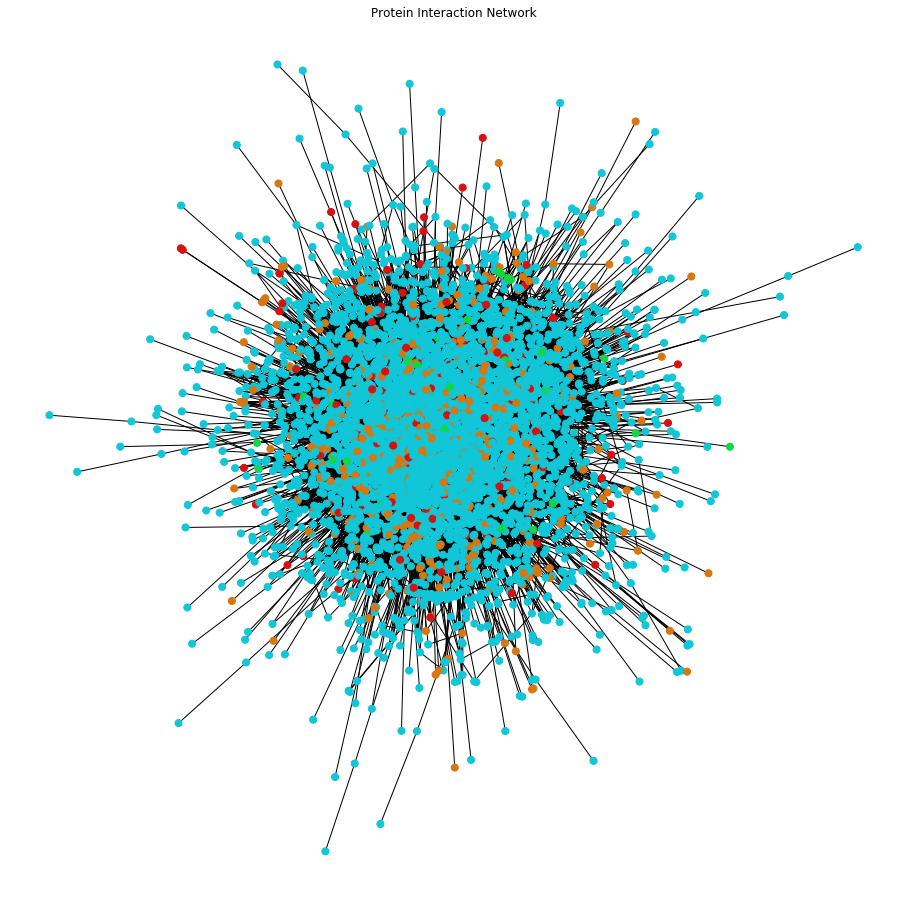

In [8]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network')
nx.draw(G_main, pos=nx.spring_layout(G_main),
        node_size=50, 
        node_color=[G_main.nodes[n]['color'] for n in G_main.nodes()], ax=ax)
plt.show()

**Network Facts**

In [122]:
def calculate_DegreezScore(G,i):
    # This function calculates the degree z-score of node i, given graph G
    #
    # input  : G, anetworkx simple graph with n nodes
    #        : i, a node in G
    # output : z_i, the degree z-score
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ### YOUR CODE (my code: 5 lines, plus return)
    xbar = (2* G.number_of_edges())/G.number_of_nodes()
    sum_val = 0
    for n in G.nodes:
        sum_val += (G.degree(n) - xbar)**2
    sigma = np.sqrt(sum_val/(G.number_of_nodes()-1))
    return ((G.degree(i)-xbar)/sigma)

In [123]:
n = G_main.number_of_nodes()
m = G_main.number_of_edges()
k = (2*m)/n
C = nx.transitivity(G_main)

# from PS 3 
def compute_MGD(G):
    # input : a networkx graph G
    # output: the mean geodesic path length (defined in Lecture 2)
    
    sum = 0
    for node in G.nodes():
        sum += single_source(G, node)
    return sum/G.number_of_nodes()
    
def single_source(G, node):
    # sssp is the list of all shortest paths from a source node. It will not include infite paths. It will include 0 paths.
    sssp = dict(nx.single_source_shortest_path(G, node))
    
    # z is the number of non-infinite and non-zero pairwise distances being summed over. 
    z = 0
    # the sum of all path lengths which are non-zero and non-infinite
    sum_dist = 0
    
    for target in sssp:
        # This will remove and paths with len 0 from the apsp dict.
        if target != node:
            # using the -1 will give accurate path lengths rather than node count.
            sum_dist += len(sssp[target]) -1
            z += 1
    # return the mean of the shortest pairwise distances
    return sum_dist/z

zscore = []
for i in G_main.nodes():
    zscore.append(calculate_DegreezScore(G_main, i))
zscore_std = np.std(zscore)
mean_zscore = np.mean(zscore)

ellmean = compute_MGD(G_main)


print("Overall")
print('Number of nodes: {}'.format(n))
print('Number of edges: {}'.format(m))
print('Average Degree: {}'.format(k))
print('Clustering coefficient: {}'.format(C))
print('Avergae Degree Z Score: {}'.format(mean_zscore))
print('Zscore std: {}'.format(zscore_std))

Overall
Number of nodes: 5128
Number of edges: 31189
Average Degree: 12.164196567862714
Clustering coefficient: 0.11792861223960432
Avergae Degree Z Score: 2.2169820148521067e-17
Zscore std: 0.9999024913458617


In [84]:
overall_longevity_nodes = [n for n in G_main.nodes() if G_main.nodes[n]['color'] != '#11c6d6']
non_longevity_nodes = [n for n in G_main.nodes() if n not in overall_longevity_nodes]
edges = 0
for n in overall_longevity_nodes:
    edges += G_main.degree(n)
ell = 0 
for n in overall_longevity_nodes:
    ell += single_source(G_main, n)
ellmean = ell/len(overall_longevity_nodes)

zscore = []
for i in overall_longevity_nodes:
    zscore.append(calculate_DegreezScore(G_main, i))
zscore_std = np.std(zscore)
mean_zscore = np.mean(zscore)
    
print("All Longevity Nodes")
print("Number of Longevity Nodes: {}".format(len(overall_longevity_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(overall_longevity_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Mean Degree Z Score: {}'.format(mean_zscore))
print('Zscore std: {}'.format(zscore_std))

All Longevity Nodes
Number of Longevity Nodes: 739
Number of in/out edges: 9250
Average Degree: 12.516914749661705
Mean Geodesic Distance: 3.6796154403456685
Mean Degree Z Score: 0.020054977943616093
Zscore std: 0.9018725117082619


In [85]:
for n in non_longevity_nodes:
    edges += G_main.degree(n)
ell = 0 
for n in non_longevity_nodes:
    ell += single_source(G_main, n)
ellmean = ell/len(non_longevity_nodes)

zscore = []
for i in non_longevity_nodes:
    zscore.append(calculate_DegreezScore(G_main, i))
zscore_std = np.std(zscore)
mean_zscore = np.mean(zscore)
    
print("Non Longevity Nodes")
print("Number of Longevity Nodes: {}".format(len(non_longevity_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(non_longevity_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Avergae Degree Z Score: {}'.format(mean_zscore))
print('Zscore std: {}'.format(zscore_std))

Non Longevity Nodes
Number of Longevity Nodes: 4389
Number of in/out edges: 62378
Average Degree: 14.212349054454318
Mean Geodesic Distance: 3.683189924204986
Avergae Degree Z Score: -0.0033767666211738717
Zscore std: 1.0154389556405823


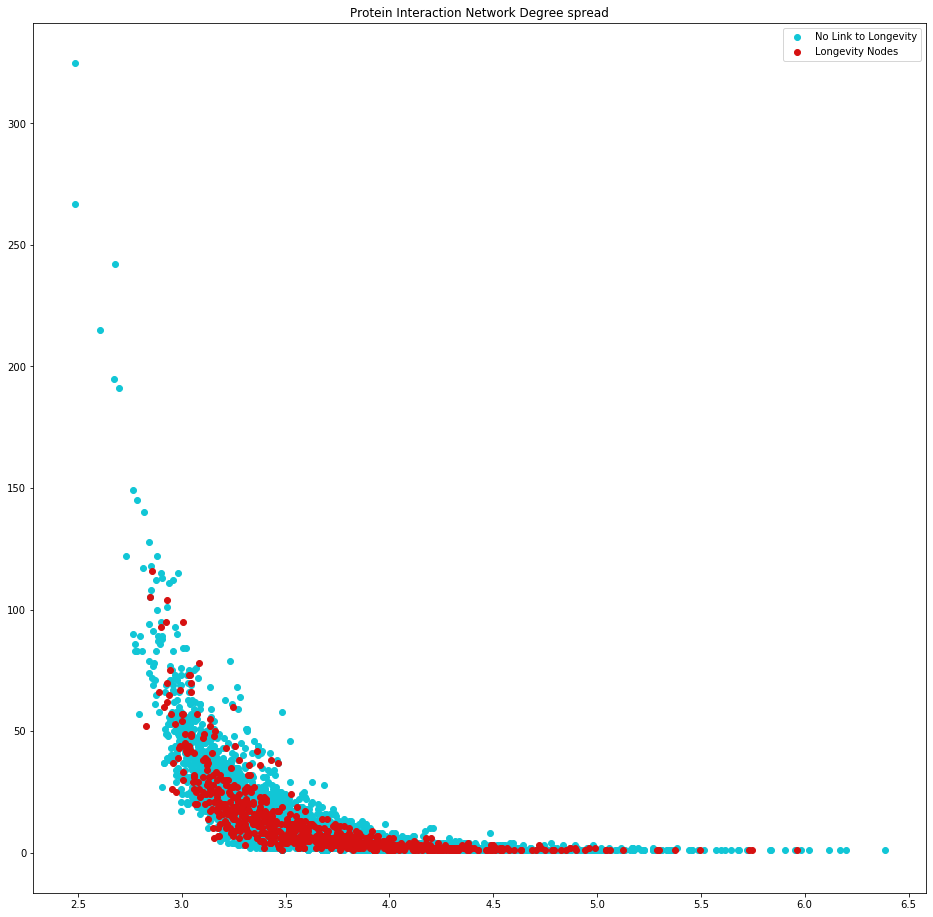

In [86]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Degree spread')
ax.scatter([single_source(G_main, n) for n in non_longevity_nodes],
           [G_main.degree(n) for n in non_longevity_nodes],
            color='#11c6d6', label='No Link to Longevity')
ax.scatter([single_source(G_main, n) for n in overall_longevity_nodes],
           [G_main.degree(n) for n in overall_longevity_nodes],
            color='#d61111', label='Longevity Nodes')
ax.legend()
plt.show()

In [88]:
def get_stats(G, color):
    longevity_nodes = [n for n in G.nodes if G_main.nodes[n]['color'] == color]
    edges = 0
    for n in longevity_nodes:
        edges += G.degree(n)
    
    ell = 0 
    for n in longevity_nodes:
        ell += single_source(G, n)
    ellmean = ell/len(longevity_nodes)
    zscore = []
    for i in longevity_nodes:
        zscore.append(calculate_DegreezScore(G_main, i))
    zscore_std = np.std(zscore)
    mean_zscore = np.mean(zscore)
    return longevity_nodes, edges, ellmean, zscore_std, mean_zscore

pro_nodes, edges, ellmean, zscore_std, mean_zscore = get_stats(G_main, '#11d646')
print("Pro Longevity Nodes")
print("Number of Nodes: {}".format(len(pro_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(pro_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Avergae Degree Z Score: {}'.format(mean_zscore))
print('Zscore std: {}'.format(zscore_std))

Pro Longevity Nodes
Number of Nodes: 50
Number of in/out edges: 587
Average Degree: 11.74
Mean Geodesic Distance: 3.6642598010532463
Avergae Degree Z Score: -0.024119121869063526
Zscore std: 0.9476643024845358


In [89]:
anti_nodes, edges, ellmean, zscore_std, mean_zscore = get_stats(G_main, '#d61111')
print("Anti Longevity Nodes")
print("Number of Nodes: {}".format(len(anti_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(anti_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Avergae Degree Z Score: {}'.format(mean_zscore))
print('Zscore std: {}'.format(zscore_std))

Anti Longevity Nodes
Number of Nodes: 217
Number of in/out edges: 3708
Average Degree: 17.087557603686637
Mean Geodesic Distance: 3.5906635063848302
Avergae Degree Z Score: 0.2799342423413173
Zscore std: 1.1568020934688654


In [90]:
fit_nodes, edges, ellmean, zscore_std, mean_zscore = get_stats(G_main, '#d67711')
print("Fitness Longevity Nodes")
print("Number of Longevity Nodes: {}".format(len(fit_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(fit_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))
print('Avergae Degree Z Score: {}'.format(mean_zscore))
print('Zscore std: {}'.format(zscore_std))

Fitness Longevity Nodes
Number of Longevity Nodes: 472
Number of in/out edges: 4955
Average Degree: 10.497881355932204
Mean Geodesic Distance: 3.7221373717738966
Avergae Degree Z Score: -0.09474395295398391
Zscore std: 0.720197450675992


In [59]:
non_nodes, edges, ellmean = get_stats(G_main, '#11c6d6')
print("Non Longevity Nodes")
print("Number of Nodes: {}".format(len(non_nodes)))
print("Number of in/out edges: {}".format(edges))
print("Average Degree: {}".format(edges/len(non_nodes)))
print("Mean Geodesic Distance: {}".format(ellmean))

Non Longevity Nodes
Number of Nodes: 4389
Number of in/out edges: 53128
Average Degree: 12.104807473228526
Mean Geodesic Distance: 3.683189924204986


In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Degree spread')
ax.scatter([np.log(single_source(G_main, n)) for n in non_nodes],
           [np.log(G_main.degree(n)) for n in non_nodes],
            color='#11c6d6', label='non longevity')
ax.scatter([np.log(single_source(G_main, n)) for n in fit_nodes],
           [np.log(G_main.degree(n)) for n in fit_nodes],
            color='#d67711', label='fitness')
ax.scatter([np.log(single_source(G_main, n)) for n in anti_nodes],
           [np.log(G_main.degree(n)) for n in anti_nodes],
            color='#d61111', label='anti Longevity')
ax.scatter([np.log(single_source(G_main, n)) for n in pro_nodes],
           [np.log(G_main.degree(n)) for n in pro_nodes],
            color='#11d646', label='pro Longevity')
ax.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Average Shortest Path')

labels=['non longevity','fitness', 'anti', 'pro']
colors = ['#11c6d6', '#d67711','#d61111', '#11d646']
plt.hist([[single_source(G_main, n) for n in non_nodes],
          [single_source(G_main, n) for n in fit_nodes],
          [single_source(G_main, n) for n in anti_nodes],
          [single_source(G_main, n) for n in pro_nodes]],
         bins=13, label=labels, color=colors, density=True, stacked=False)
ax.legend()
fig.tight_layout()
plt.show()

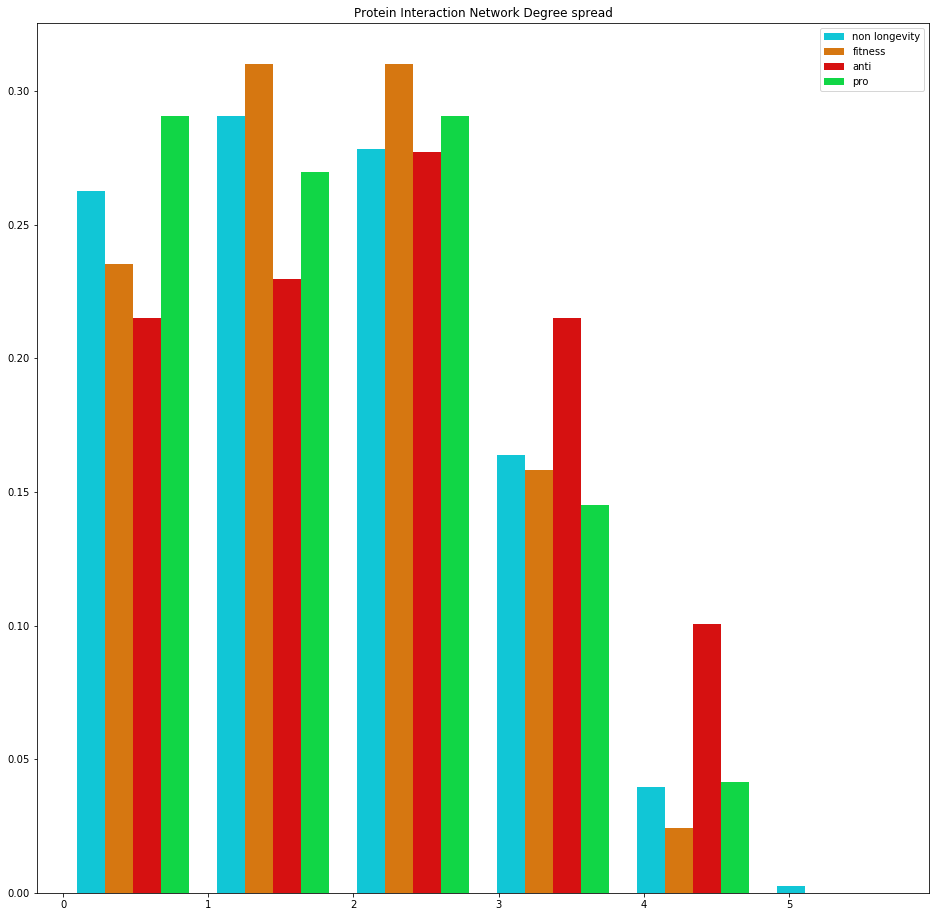

In [105]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Degree spread')

labels=['non longevity','fitness', 'anti', 'pro']
colors = ['#11c6d6', '#d67711','#d61111', '#11d646']
plt.hist([[np.log(G_main.degree(n)) for n in non_nodes],
          [np.log(G_main.degree(n)) for n in fit_nodes],
          [np.log(G_main.degree(n)) for n in anti_nodes],
          [np.log(G_main.degree(n)) for n in pro_nodes]],
         bins=6,color=colors, label=labels, density=True)
ax.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Average Shortest Path')

labels=['non longevity','fitness', 'anti', 'pro']
colors = ['#11c6d6', '#d67711','#d61111', '#11d646']
plt.hist([[np.log(calculate_DegreezScore(G_main, n)) for n in non_nodes],
          [np.log(calculate_DegreezScore(G_main, n)) for n in fit_nodes],
          [np.log(calculate_DegreezScore(G_main, n)) for n in anti_nodes],
          [np.log(calculate_DegreezScore(G_main, n)) for n in pro_nodes]],
         bins=5, label=labels, color=colors, density=True, stacked=False)
ax.legend()
fig.tight_layout()
plt.show()

In [124]:
def calculate_Participation(G,z,i):
    # This function calculates the participation coefficient of node i, given graph G and partition z
    #
    # input  : G, anetworkx simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes
    #        : i, a node in G
    # output : P_i, the participation coefficient
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ### YOUR CODE (my code: 9 lines, plus return)
    
    groups = {}
    sum_val = 0
    for n in G.neighbors(i):
        if z[n] not in groups:
            groups[z[n]] = 1
        else:
            groups[z[n]] +=1
    for g in groups:
        sum_val += (groups[g]/G.degree(i))**2
    return 1- sum_val

In [125]:
z = {x: G_main.nodes[x]['gt'] for x in G_main.nodes()}
pairs = {i: [calculate_Participation(G_main, z, i), calculate_DegreezScore(G_main, i)] for i in G_main.nodes()}

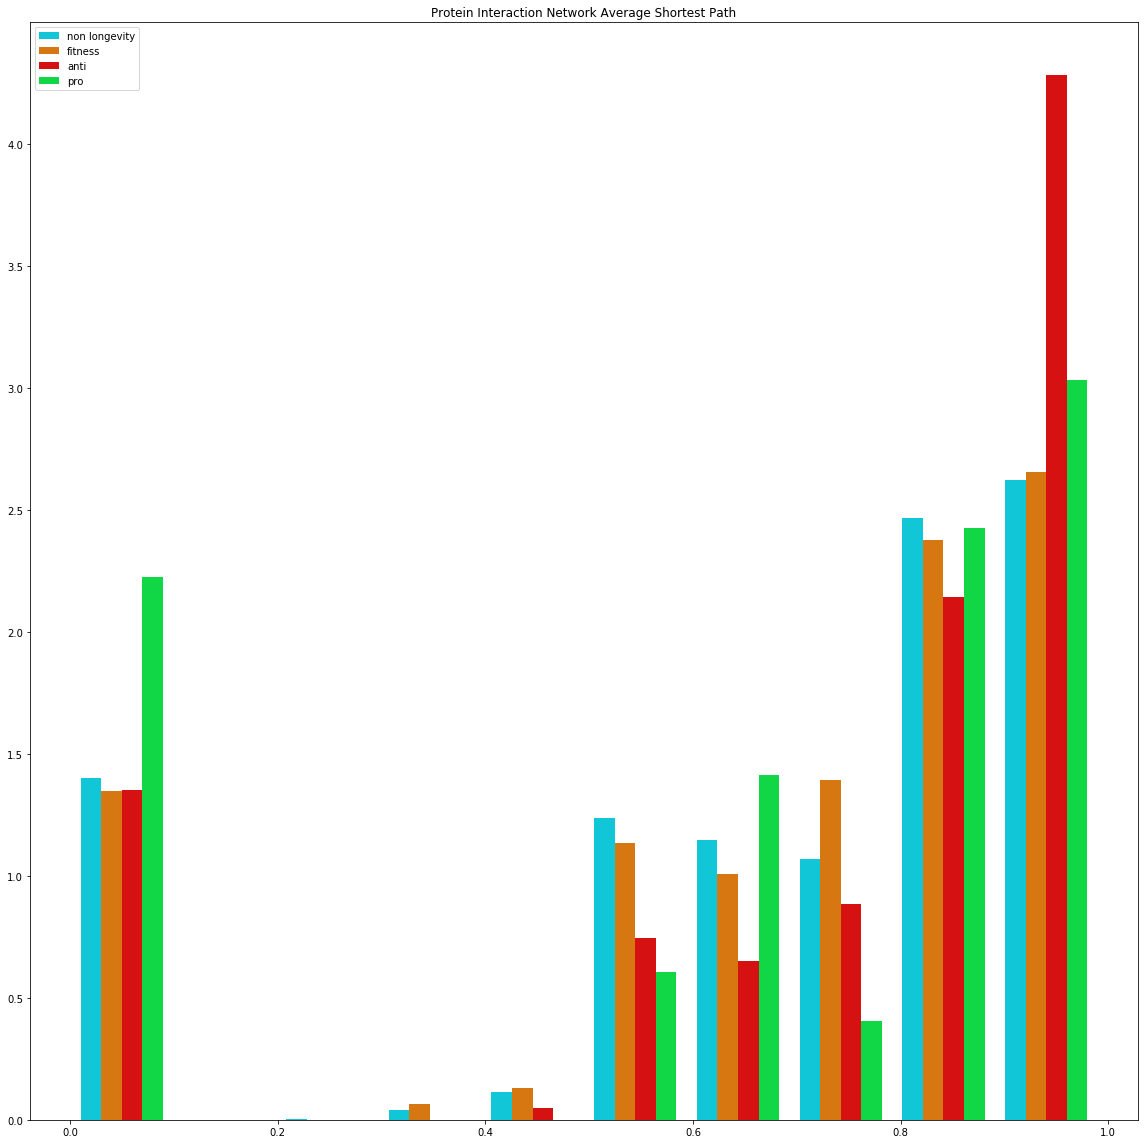

In [128]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.set_title('Protein Interaction Network Average Shortest Path')

labels=['non longevity','fitness', 'anti', 'pro']
colors = ['#11c6d6', '#d67711','#d61111', '#11d646']
plt.hist([[calculate_Participation(G_main, z, n) for n in non_nodes],
          [calculate_Participation(G_main, z, n) for n in fit_nodes],
          [calculate_Participation(G_main, z, n) for n in anti_nodes],
          [calculate_Participation(G_main,z, n) for n in pro_nodes]],
         bins=10, label=labels, color=colors, density=True, stacked=False)
ax.legend()
fig.tight_layout()
plt.show()

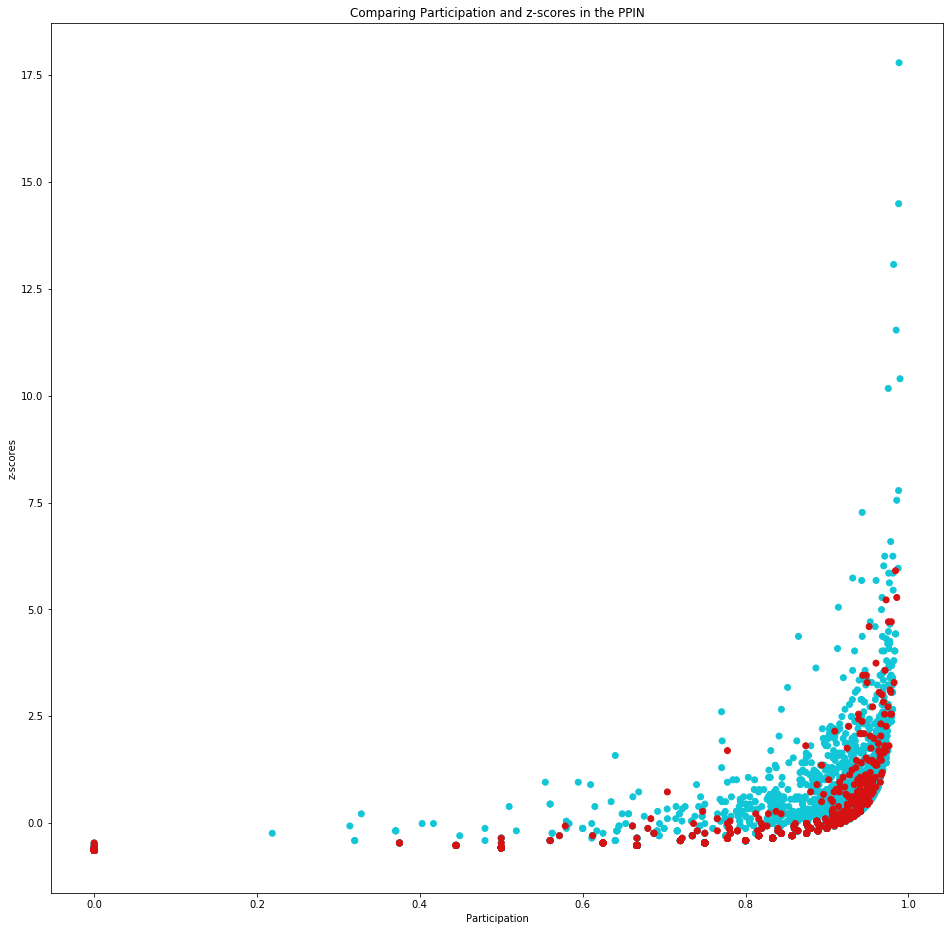

In [126]:
def make_scatter(pairs):
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(111) # put multiple
    plt.scatter([pairs[n][0] for n in non_nodes],
                [pairs[n][1] for n in non_nodes],
                color=[G_main.nodes[x]['color'] for x in non_nodes])  # plot the S(t) time series
    
    plt.scatter([pairs[n][0] for n in overall_longevity_nodes],
                [pairs[n][1] for n in overall_longevity_nodes],
                color=['#d61111' for x in overall_longevity_nodes])  # plot the S(t) time series
    #plt.scatter([pairs[n][0] for n in fit_nodes],
    #            [pairs[n][1] for n in fit_nodes],
    #            color=[G_main.nodes[x]['color'] for x in fit_nodes])  # plot the S(t) time series
    #plt.scatter([pairs[n][0] for n in anti_nodes],
    #            [pairs[n][1] for n in anti_nodes],
    #            color=[G_main.nodes[x]['color'] for x in anti_nodes])  # plot the S(t) time series
    #plt.scatter([pairs[n][0] for n in pro_nodes],
    #            [pairs[n][1] for n in pro_nodes],
    #            color=[G_main.nodes[x]['color'] for x in pro_nodes])  # plot the S(t) time series
    plt.ylabel('z-scores')
    plt.xlabel('Participation')
    plt.title('Comparing Participation and z-scores in the PPIN')
    plt.show()
    
make_scatter(pairs)

In [30]:
worm_file = 'worm_genage_models_export.tsv'
df_worm = pd.read_csv(worm_file, sep=r'\t', engine='python')
df_worm.head(20)

,Gene ID,Entrez Gene ID,Gene Symbol,Gene Name,Organism,Unigene ID,Ensembl ID,UniProt ID,Alias,Lifespan Effect,Phenotype Description,Longevity Influence,Max Lifespan Change,Avg Lifespan Change,Method,Bibliographic reference
0,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,decrease,Could be a sensor that couples energy levels a...,pro,NaN,12.0,Knockout,"2232: Apfeld et al. (2004) ""The AMP-activated ..."
1,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,decrease,37% decrease in median lifespna in daf-2 backg...,pro,NaN,54.0,RNA interference,"2239: Samuelson et al. (2007) ""Gene activities..."
2,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,pro,NaN,NaN,Overexpression,"4423: Burkewitz et al. (2015) ""Neuronal CRTC-1..."
3,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increase,Transgenic animals with a higher aak-2 gene do...,pro,NaN,13.0,Overexpression,"2232: Apfeld et al. (2004) ""The AMP-activated ..."
4,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,NaN,NaN,NaN,Overexpression,"4515: Tabrez et al. (2017) ""Differential alter..."
5,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,pro,NaN,NaN,Overexpression,"4515: Tabrez et al. (2017) ""Differential alter..."
6,1,181727.0,aak-2,AMP-Activated Kinase,Caenorhabditis elegans,Cel.17479,T01C8.1,NaN,NaN,increases,Constitutively activated aak-2 increased worm ...,pro,NaN,NaN,Overexpression,"4515: Tabrez et al. (2017) ""Differential alter..."
7,269,181492.0,aakb-1,AMP-Activated Kinase Beta subunit,Caenorhabditis elegans,Cel.860,F55F3.1,NaN,NaN,decrease,RNA interference resulted in decreased lifespa...,pro,NaN,NaN,RNA interference,"2290: Ha et al. (2006) ""Caenorhabditis elegans..."
8,752,176552.0,aakb-2,AMP-Activated Kinase Beta subunit,Caenorhabditis elegans,Cel.9773,Y47D3A.15,NaN,NaN,decrease,RNA interference resulted in decreased lifespa...,pro,NaN,NaN,RNA interference,"2290: Ha et al. (2006) ""Caenorhabditis elegans..."
9,1849,181736.0,aakg-2,Protein AAKG-2,Caenorhabditis elegans,NaN,NaN,NaN,NaN,increase,"aakg-2 overexpression extends mean, median, an...",pro,35,47.0,Overexpression,"2588: Sagi and Kim (2012) ""An engineering appr..."


In [53]:
mus_file = 'mus_genage_models_export.tsv'
df_mus = pd.read_csv(mus_file, sep=r'\t', engine='python')
df_mus.head(20)

,Gene ID,Entrez Gene ID,Gene Symbol,Gene Name,Organism,Unigene ID,Ensembl ID,UniProt ID,Alias,Lifespan Effect,Phenotype Description,Longevity Influence,Max Lifespan Change,Avg Lifespan Change,Method,Bibliographic reference
0,6,224129,Adcy5,adenylate cyclase 5,Mus musculus,Mm.41137,ENSMUSG00000022840,P84309,Ac5 AW121902,increase,Knock out mice are resistant to cardiac stress...,anti,12,30.0,Knockout,"1845: Yan et al. (2007) ""Type 5 adenylyl cycla..."
1,1953,11549,Adra1a,"adrenergic receptor, alpha 1a",Mus musculus,NaN,NaN,NaN,NaN,increase,Transgenic mice overexpressing a CAM form of t...,pro,8,10.0,Overexpression,"3541: Doze et al. (2011) ""Long-term Î±1A-adren..."
2,1954,11548,Adra1b,"adrenergic receptor, alpha 1b",Mus musculus,NaN,NaN,NaN,NaN,decrease,Transgenic mice overexpressing a CAM form of t...,anti,NaN,11.0,Overexpression,"3542: Collette et al. (2014) ""Long-term Î±1B-a..."
3,811,11607,Agtr1a,"Angiotensin II receptor, type 1a",Mus musculus,NaN,ENSMUSG00000049115,NaN,AT1 AG2S AT1a AT2R1 Agtr1 AT2R1A Agtr-1a AI551...,increase,KO mice showed a significant prolongation of a...,anti,24,26.0,Knockout,"2148: Benigni et al. (2009) ""Disruption of the..."
4,1810,11651,Akt1,thymoma viral proto-oncogene 1,Mus musculus,NaN,NaN,NaN,Akt PKB Rac PKB/Akt PKBalpha,increase,Haploinsufficient mice had a lower body weight...,anti,NaN,11.5,Genetic reduction,"3259: Nojima et al. (2013) ""Haploinsufficiency..."
5,2231,11652,Akt2,thymoma viral proto-oncogene 2,Mus musculus,NaN,NaN,NaN,NaN,increase,Akt2-/- mice exhibited a 9.1% increase in mean...,anti,NaN,9.0,Deletion,"4770: Ren et al. (2017) ""Akt2 ablation prolong..."
6,812,11816,Apoe,Apolipoprotein E,Mus musculus,NaN,ENSMUSG00000002985,NaN,AI255918,decrease,The mutant mice show dysregulations in lipid m...,pro,NaN,NaN,Knockout,"2138: Moghadasian et al. (2001) ""Pathophysiolo..."
7,13,228359,Arhgap1,Rho GTPase activating protein 1,Mus musculus,Mm.463444,ENSMUSG00000027247,Q5FWK3,C76222 Cdc42GAP p50rhoGAP RP23-12H6.2 B230365D...,decrease,Most knockout mice were weak and died during t...,pro,NaN,NaN,Knockout,"1840: Wang et al. (2007) ""Cdc42 GTPase-activat..."
8,15,11865,Arntl,aryl hydrocarbon receptor nuclear translocator...,Mus musculus,Mm.440371,ENSMUSG00000055116,Q9WTL8,MOP3 Arnt3 Bmal1 BMAL1b bHLHe5 bmal1b',decrease,Knockout mice display symptoms of premature ag...,pro,NaN,NaN,Knockout,"1841: Kondratov et al. (2006) ""Early aging and..."
9,1862,11793,Atg5,autophagy related 5,Mus musculus,NaN,NaN,NaN,NaN,increase,Overexpression of Atg5 extends median lifespan...,pro,NaN,17.0,Overexpression,"3492: Pyo et al. (2013) ""Overexpression of Atg..."
